# Import

In [1]:
from model import ChessNet
import torch
import torch.nn as nn
from torchsummary import summary
import pandas as pd
from utils import read_pgn
import chess
from IPython.display import display, clear_output
from time import sleep
from torch.utils.data import DataLoader, Dataset
from typing import List, Tuple
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle
import os

# Model

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ChessNet(
    num_classes=64,
    num_channels=6,
    activation=nn.LeakyReLU(inplace=True),
).to(device)

In [3]:
# load model
# model.load_state_dict(torch.load("piece_grouped_sel_ce_20epc.pth"))

In [4]:
# summary(model, (6, 8, 8), batch_size=1)

# Data preprocessing

In [5]:
df1 = pd.read_csv("../games_metadata_profile.csv")
df2 = pd.read_csv("../games_metadata_profile_2024_01.csv")


def format_game_mode(x):
    if "Classical" in x:
        return "Classical game"
    elif "Bullet" in x:
        return "Bullet game"
    elif "Blitz" in x:
        return "Blitz game"
    elif "UltraBullet" in x:
        return "UltraBullet game"
    elif "Rapid" in x:
        return "Rapid game"
    elif "Correspondence" in x:
        return "Correspondence game"
    else:
        return x


df = pd.concat([df1, df2], ignore_index=True)

df["Mode"] = df["Event"].apply(format_game_mode)

df = df[df["Mode"] == "Blitz game"]

In [12]:
df_elo_below_1450 = df[(df["WhiteElo"] + df["BlackElo"]) / 2 <= 1450]
df_elo_1450_to_1800 = df[
    ((df["WhiteElo"] + df["BlackElo"]) / 2 > 1450)
    & ((df["WhiteElo"] + df["BlackElo"]) / 2 <= 1800)
]
df_elo_above_1800 = df[(df["WhiteElo"] + df["BlackElo"]) / 2 > 1800]

print(f"# games with average elo below 1450: {df_elo_below_1450.shape}")

print(f"# games with average elo between 1450 and 1800: {df_elo_1450_to_1800.shape}")

print(f"# games with average elo above 1800: {df_elo_above_1800.shape}")

# games with average elo below 1450: (30057, 34)
# games with average elo between 1450 and 1800: (32038, 34)
# games with average elo above 1800: (31863, 34)


In [13]:
cutoff = 15000  # number of games to use for each partition

df_elo_below_1450 = df_elo_below_1450.sample(cutoff)

df_elo_1450_to_1800 = df_elo_1450_to_1800.sample(cutoff)

df_elo_above_1800 = df_elo_above_1800.sample(cutoff)

print(f"# games with average elo below 1450: {df_elo_below_1450.shape}")

print(f"# games with average elo between 1450 and 1800: {df_elo_1450_to_1800.shape}")

print(f"# games with average elo above 1800: {df_elo_above_1800.shape}")

# games with average elo below 1450: (15000, 34)
# games with average elo between 1450 and 1800: (15000, 34)
# games with average elo above 1800: (15000, 34)


In [14]:
# move ==> (_from, _to, board)
# board ==> 8x8 numpy array
def process_game(moves: List[chess.Move]):
    board = chess.Board()
    samples = []
    for move in moves:
        _from, _to = move.uci()[:2], move.uci()[2:]
        piece = board.piece_at(chess.parse_square(_from))
        samples.append((str(_from), str(_to), str(piece), board.fen()))
        board.push(move)

    return samples

In [15]:
def pgns_to_samples(
    game_pgns: List[str] = None, save_dir: str = None, suffix: str = ""
):
    assert (
        game_pgns is not None or save_dir is not None
    ), "game_pgns OR save_dir must be provided"

    is_train_saved = False
    is_test_saved = False
    train_samples = []
    test_samples = []
    if save_dir:
        if f"train_{suffix}.pkl" in os.listdir(save_dir):
            print("Loading train samples from disk")
            is_train_saved = True
            with open(f"{save_dir}/train_{suffix}.pkl", "rb") as f:
                train_samples = pickle.load(f)

        if f"test_{suffix}.pkl" in os.listdir(save_dir):
            print("Loading test samples from disk")
            is_test_saved = True
            with open(f"{save_dir}/test_{suffix}.pkl", "rb") as f:
                test_samples = pickle.load(f)

    if game_pgns is not None:
        train_pgn, test_pgn = train_test_split(
            game_pgns, test_size=0.2, random_state=42
        )

        if not is_train_saved:
            print("Processing train samples")
            for game_pgn in tqdm(train_pgn):
                grouped_moves = read_pgn(game_pgn)
                train_samples.extend(process_game(grouped_moves))

            with open(f"{save_dir}/train_{suffix}.pkl", "wb") as f:
                pickle.dump(train_samples, f)
                print(f"Train samples saved to {save_dir}/train_{suffix}.pkl")

        if not is_test_saved:
            print("Processing test samples")
            for game_pgn in tqdm(test_pgn):
                grouped_moves = read_pgn(game_pgn)
                test_samples.extend(process_game(grouped_moves))
            with open(f"{save_dir}/test_{suffix}.pkl", "wb") as f:
                pickle.dump(test_samples, f)
                print(f"Test samples saved to {save_dir}/test_{suffix}.pkl")

    return train_samples, test_samples

In [16]:
game_below_1450 = df_elo_below_1450["Moves"].values
game_1450_to_1800 = df_elo_1450_to_1800["Moves"].values
game_above_1800 = df_elo_above_1800["Moves"].values

In [17]:
train_below_1450, test_below_1450 = pgns_to_samples(
    save_dir="data", suffix="below_1450_15kCUTOFF", game_pgns=game_below_1450
)
train_1450_to_1800, test_1450_to_1800 = pgns_to_samples(
    save_dir="data", suffix="1450_to_1800_15kCUTOOF", game_pgns=game_1450_to_1800
)
train_above_1800, test_above_1800 = pgns_to_samples(
    save_dir="data", suffix="above_1800_15kCUTOFF", game_pgns=game_above_1800
)

Processing train samples


100%|██████████| 12000/12000 [00:39<00:00, 304.46it/s]


Train samples saved to data/train_below_1450_15kCUTOFF.pkl
Processing test samples


100%|██████████| 3000/3000 [00:09<00:00, 300.60it/s]


Test samples saved to data/test_below_1450_15kCUTOFF.pkl
Processing train samples


100%|██████████| 12000/12000 [00:43<00:00, 273.08it/s]


Train samples saved to data/train_1450_to_1800_15kCUTOOF.pkl
Processing test samples


100%|██████████| 3000/3000 [00:11<00:00, 259.37it/s]


Test samples saved to data/test_1450_to_1800_15kCUTOOF.pkl
Processing train samples


100%|██████████| 12000/12000 [00:48<00:00, 245.13it/s]


Train samples saved to data/train_above_1800_15kCUTOFF.pkl
Processing test samples


100%|██████████| 3000/3000 [00:12<00:00, 242.48it/s]


Test samples saved to data/test_above_1800_15kCUTOFF.pkl


In [18]:
print(f"# train samples below 1450: {len(train_below_1450)}")
print(f"# train samples between 1450 and 1800: {len(train_1450_to_1800)}")
print(f"# train samples above 1800: {len(train_above_1800)}")

Number of train samples below 1450: 738908
Number of train samples between 1450 and 1800: 796075
Number of train samples above 1800: 871431


In [16]:
def filter_by_piece(samples: List[Tuple[str, str, str, str]], piece: str):
    return list(filter(lambda x: x[2].lower() == piece, samples))

In [ ]:
# encode board into 6 channel tensor
# each channel represents a different type of piece
# 0: empty square
# 1: white pieces, 2: black pieces
# 1st channel: pawns, 2nd channel: knights, 3rd channel: bishops
# 4th channel: rooks, 5th channel: queens, 6th channel: kings
def transform_board(board, mask_loc: str = None) -> torch.Tensor:
    piece_map = {
        "p": 1,
        "n": 2,
        "b": 3,
        "r": 4,
        "q": 5,
        "k": 6,
    }
    board_tensor = torch.zeros(6, 8, 8)
    for i in range(8):
        for j in range(8):
            piece = board.piece_at(chess.square(i, j))
            if piece is not None:
                color = 1 if piece.color == chess.WHITE else -1
                piece_symbol = piece.symbol().lower()
                board_tensor[piece_map[piece_symbol] - 1, i, j] = color

    if mask_loc is not None:  # add new channels of mask to the board tensor
        mask_tensor = torch.zeros(1, 8, 8)
        # convert mask_loc san to square index
        mask_square = chess.parse_square(mask_loc)
        piece = board.piece_at(mask_square)
        if piece is None:
            raise ValueError(f"no piece at mask square {mask_loc}")
        mask_tensor[0, mask_square % 8, mask_square // 8] = (
            1 if piece.color == chess.WHITE else -1
        )
        board_tensor = torch.cat((board_tensor, mask_tensor), dim=0)

    return board_tensor

In [82]:
# group samples with the same board state, produce a probability distribution of moves, ingore the move


# sample ==> {board: {
#   piece: count
# }}
def group_board(samples):
    board_grouped = {}
    # count the number of moves for each piece in each board state
    for sample in samples:
        _from, _to, board_fen = sample

        board_position = board_fen.split(" ")[0]

        if board_position not in board_grouped:
            board_grouped[board_position] = {"total": 0}

        if _from not in board_grouped[board_position]:
            board_grouped[board_position][_from] = 0

        board_grouped[board_position]["total"] += 1
        board_grouped[board_position][_from] += 1
    # convert the count to probability distribution
    for board_position in board_grouped:
        total = board_grouped[board_position]["total"]
        for _from in board_grouped[board_position]:
            if _from == "total":
                continue
            board_grouped[board_position][_from] /= total
        del board_grouped[board_position]["total"]
    # dict to list
    board_grouped = list(board_grouped.items())

    return board_grouped

In [ ]:
# transform piece distribution to tensor label
# piece_distribution = {'e1': 0.5, 'd2': 0.2, ...}
# piece_distribution ==> tensor(64)
def piece_distribution_to_label(piece_distribution):
    label = torch.zeros(64)
    for i, piece in enumerate(piece_distribution):
        idx = chess.parse_square(piece)
        label[idx] = piece_distribution[piece]

    return label

In [83]:
grouped_train_samples = group_board(train_below_1450)
grouped_test_samples = group_board(test_below_1450)

len(grouped_train_samples), len(grouped_test_samples)

(159228, 40500)

In [ ]:
bishop_train_below_1450 = filter_by_piece(train_below_1450, "b")

len(bishop_train_below_1450)

232254

# Dataset

In [85]:
class PieceSelectionGroupedDataset(Dataset):
    def __init__(self, grouped_moves: List[Tuple[str, dict]]):
        self.grouped_moves = grouped_moves

    def __len__(self):
        return len(self.grouped_moves)

    def __getitem__(self, idx):
        board_fen, piece_prob = self.grouped_moves[idx]
        board = chess.Board(board_fen)
        # feature is the board tensor
        x = transform_board(board)
        # label is one-hot encoded _from
        y = piece_distribution_to_label(piece_prob)
        # if play side is black, flip the board both two ways and the label
        if board.turn == chess.BLACK:
            x = x.flip(1).flip(2)
            y = y.flip(0)

        return x, y

In [86]:
class PieceSelectionDataset(Dataset):
    def __init__(self, moves: List[Tuple[str, str, str]]):
        self.moves = moves

    def __len__(self):
        return len(self.moves)

    def __getitem__(self, idx):
        _from, _to, board_fen = self.moves[idx]
        board = chess.Board(board_fen)
        # feature is the board tensor
        x = transform_board(board)
        # label is one-hot encoded _from
        y = torch.zeros(64)
        y[chess.parse_square(_from)] = 1
        # if play side is black, flip the board both two ways and the label
        if board.turn == chess.BLACK:
            x = x.flip(1).flip(2)
            y = y.flip(0)

        return x, y

In [87]:
piece_sel_ds = PieceSelectionGroupedDataset(grouped_train_samples)
piece_sel_dl = DataLoader(piece_sel_ds, batch_size=64, shuffle=True)

# sample from the dataset
x, y = piece_sel_ds[0]

x.shape, y.shape, len(piece_sel_ds)

(torch.Size([6, 8, 8]), torch.Size([64]), 159228)

# Training piece selection

In [19]:
EPOCHS = 10
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_history = []

for epoch in range(EPOCHS):
    clear_output(wait=True)
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print("-" * 10)

    # TRAIN PIECE SELECTION MODEL
    model.train()
    piece_selection_loss = 0.0
    for idx, (x, y) in enumerate(piece_sel_dl):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        piece_selection_loss += loss.item()
        if idx % 200 == 0:
            print(f"batch {idx} loss: {loss.item()}")
            loss_history.append(loss.item())
    print(f"__Epoch loss: {piece_selection_loss/len(piece_sel_dl)}")

Epoch 10/10
----------
batch 0 loss: 4.106743812561035
batch 200 loss: 4.054723739624023
batch 400 loss: 4.028746128082275
batch 600 loss: 4.072626113891602
batch 800 loss: 4.060213088989258
batch 1000 loss: 4.090933322906494
batch 1200 loss: 4.06001091003418
batch 1400 loss: 4.10654354095459
batch 1600 loss: 4.091612815856934
batch 1800 loss: 4.138007164001465
batch 2000 loss: 4.028840065002441
batch 2200 loss: 4.063558578491211
batch 2400 loss: 4.138141632080078
__Epoch loss: 4.079843078491389


In [20]:
# save the model
torch.save(model.state_dict(), "grouped_ce_10epc_lrelu_0.01.pth")

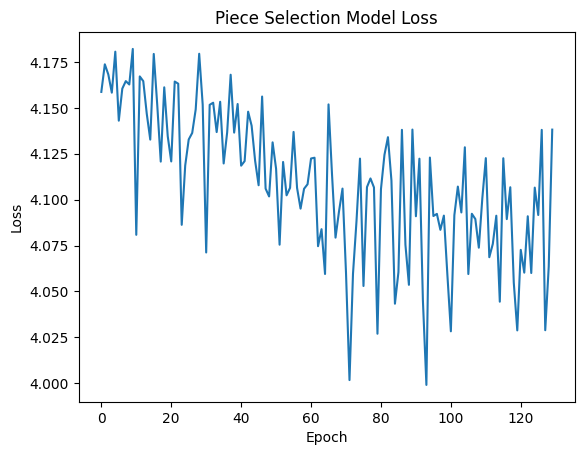

In [21]:
# plot loss history
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Piece Selection Model Loss")
plt.show()

# Evaluation

In [88]:
test_samples_ds = PieceSelectionDataset(test_samples)
test_samples_dl = DataLoader(test_samples_ds, batch_size=64, shuffle=False)

test_piece_sel_ds = PieceSelectionGroupedDataset(grouped_test_samples)
test_piece_sel_dl = DataLoader(test_piece_sel_ds, batch_size=64, shuffle=False)

In [89]:
# evaluate KL divergence between the predicted distribution and the true distribution
# KL divergence is a measure of how one probability distribution diverges from a second, expected probability distribution
# KL divergence is 0 if the two distributions are identical
model.eval()
kl_divergence = 0.0
for idx, (x, y) in enumerate(test_piece_sel_dl):
    x, y = x.to(device), y.to(device)
    output = model(x)
    kl_divergence += nn.KLDivLoss()(output, y).item()

kl_divergence /= len(test_piece_sel_dl)
print(f"KL Divergence: {kl_divergence}")

c:\Users\Hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\functional.py:2943: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


KL Divergence: 0.0019808672005763076


In [90]:
# evluate the distribution of the predicted move
# produce the move by sampling from the predicted distribution
from torch.distributions import Categorical


def sample_move(probs: torch.Tensor):
    # sample moves in batch
    moves = []
    for prob in probs:
        dist = Categorical(prob)
        move = dist.sample()
        pred_y = torch.zeros(64)
        pred_y[move] = 1
        moves.append(pred_y)

    return torch.stack(moves).to(device)

# get the move from argmax of the predicted distribution
def argmax_move(batch: torch.Tensor):
    argmax_idx = torch.argmax(batch, dim=1)
    pred_y = torch.zeros_like(batch)
    pred_y[torch.arange(batch.shape[0]), argmax_idx] = 1

    return pred_y.to(device)

In [91]:
model.eval()
total = 0
correct = 0
for idx, (x, y) in enumerate(test_samples_dl):
    x, y = x.to(device), y.to(device)
    output = model(x)
    output = torch.softmax(output, dim=1)
    pred_y = argmax_move(output)
    correct += (pred_y == y).all(dim=1).sum().item()
    total += y.size(0)

print(f"Accuracy argmax move: {(correct/total) * 100:.3f}%")

Accuracy: 20.174%


In [92]:
# sample move from the predicted distribution
model.eval()
total = 0
correct = 0
for idx, (x, y) in enumerate(test_samples_dl):
    x, y = x.to(device), y.to(device)
    output = model(x)
    output = torch.softmax(output, dim=1)
    pred_y = sample_move(output)
    correct += (pred_y == y).all(dim=1).sum().item()
    total += y.size(0)

print(f"Accuracy sample move: {(correct/total) * 100:.3f}%")

Accuracy: 5.233%
